![](https://github.com/destination-earth/DestinE-DataLake-Lab/blob/main/img/DestinE-banner.jpg?raw=true)

# DEDL - HDA Climate DT Parameter Plotter - Tutorial

**Author**: EUMETSAT <br>
**Copyright**: 2024 EUMETSAT <br>
**Licence**: MIT <br>
**Credit**: Earthkit and HDA Polytope used in this context are both packages provided by the European Centre for Medium-Range Weather Forecasts (**ECMWF**).

**DEDL Harmonised Data Access** is used in this example to access and plot Climate DT parameter.</br>


[Documentation DestinE DataLake HDA](https://destine-data-lake-docs.data.destination-earth.eu/en/latest/dedl-discovery-and-data-access/dedl-discovery-and-data-access.html)

[Climate DT overview](https://confluence.ecmwf.int/display/DDCZ/Climate+DT+overview)








## Import the required packages

In [103]:
pip install --quiet --upgrade destinelab

Note: you may need to restart the kernel to use updated packages.


Import the Climate DT parameter & scenario dictionary

In [84]:
from destinelab import climate_dt_dictionary
import ipywidgets as widgets
import json
import datetime

import importlib.metadata

## Climate DT parameter selection (we limit the plotting to one parameter)

In [85]:
# Create search box
search_box = widgets.Text(placeholder='Search by parameter name', description='Search:', disabled=False)

# Create dropdown to select entry
entry_dropdown = widgets.Dropdown(
    options=[(entry['paramName'], i) for i, entry in enumerate(climate_dt_dictionary.climateDT_params)],
    description='Select Entry:'
)

def filter_entries(search_string):
    return [(entry['paramName'], i) for i, entry in enumerate(climate_dt_dictionary.climateDT_params) if search_string.lower() in entry['paramName'].lower()]

def on_search_change(change):
    search_string = change.new
    if search_string:
        filtered_options = filter_entries(search_string)
        entry_dropdown.options = filtered_options
    else:
        entry_dropdown.options = [(entry['paramName'], i) for i, entry in enumerate(climate_dt_dictionary.climateDT_params)]

search_box.observe(on_search_change, names='value')

# Display widgets
display(search_box, entry_dropdown)

def get_selected_entry():
    return entry_dropdown.value


Text(value='', description='Search:', placeholder='Search by parameter name')

Dropdown(description='Select Entry:', options=(('Total column cloud liquid water', 0), ('Total column cloud ic…

In [86]:
# Print the details of the parameter (Polytope convention):
selected_index = get_selected_entry()
selected_entry = climate_dt_dictionary.climateDT_params[selected_index]
print(json.dumps(selected_entry,indent=4))

{
    "param": "167",
    "paramName": "2 metre temperature",
    "shortName": "2t",
    "unit": "K",
    "encoding": "instantaneous",
    "isNemo": "IFS-NEMO",
    "isIcon": "ICON",
    "isFESOM": "IFS-FESOM",
    "stream": "clte",
    "type": "fc",
    "time": "Hourly",
    "levtype": "sfc",
    "levelist": ""
}


## Choose now the Scenario from which we want to obtain the Climate Parameter

In [87]:
# Create dropdown to select scenario
scenario_dropdown = widgets.Dropdown(
    options=[(f"{entry['experiment']} - {entry['model']} - {resolution}", (i, resolution)) for i, entry in enumerate(climate_dt_dictionary.climateDT_scenario) for resolution in entry['resolution']],
    description='Scenario:'
)

# Function to generate hourly slots
def generate_hourly_slots():
    hours = []
    for hour in range(0, 24):
        for minute in range(0, 60, 60):  # Step by 60 minutes (1 hour)
            hours.append(datetime.time(hour, minute))
    return hours

# Create dropdown to select hour
hourly_slots = generate_hourly_slots()
hour_dropdown = widgets.Dropdown(options=[(str(slot), slot) for slot in hourly_slots], description='Select Hour:', disabled=False)

# Create date picker widgets
start_date_picker = widgets.DatePicker(description='Start Date:', disabled=False)

def on_scenario_change(change):
    selected_index, selected_resolution = change.new
    selected_sc_entry = climate_dt_dictionary.climateDT_scenario[selected_index]
    date_from = datetime.datetime.strptime(selected_sc_entry['dateFrom'], '%m/%d/%Y').date()
    start_date_picker.max = None
    start_date_picker.min = date_from
    start_date_picker.max = datetime.datetime.strptime(selected_sc_entry['dateTo'], '%m/%d/%Y').date()
    start_date_picker.value = date_from

scenario_dropdown.observe(on_scenario_change, names='value')

# Set initial values directly
selected_sc_entry = climate_dt_dictionary.climateDT_scenario[0]
# Convert dateFrom string to date object
date_from = datetime.datetime.strptime(selected_sc_entry['dateFrom'], '%m/%d/%Y').date()

# Set initial values directly
start_date_picker.min = date_from
start_date_picker.max = datetime.datetime.strptime(selected_sc_entry['dateTo'], '%m/%d/%Y').date()
start_date_picker.value = date_from

# Display widgets
if selected_entry["time"] == "Hourly":
    display(scenario_dropdown, start_date_picker, hour_dropdown)
else:
    display(scenario_dropdown, start_date_picker)

def get_selected_values():
    selected_scenario_index, selected_resolution = scenario_dropdown.value
    selected_scenario = climate_dt_dictionary.climateDT_scenario[selected_scenario_index]
    selected_start_date = start_date_picker.value
    selected_end_date = "" # end_date_picker.value
    selected_hour = "00:00:00"
    if selected_entry["time"] == "Hourly":
        selected_hour = hour_dropdown.value
        
    return selected_scenario_index, selected_scenario, selected_resolution, selected_start_date, selected_end_date, selected_hour

# Example usage:
selected_scenario_index, selected_scenario, selected_resolution, selected_start_date, selected_end_date, selected_hour = get_selected_values()


Dropdown(description='Scenario:', options=(('ssp3-7.0 - IFS-NEMO - high', (0, 'high')), ('ssp3-7.0 - IFS-NEMO …

DatePicker(value=datetime.date(2020, 1, 1), description='Start Date:', max=datetime.date(2039, 12, 30), min=da…

Dropdown(description='Select Hour:', options=(('00:00:00', datetime.time(0, 0)), ('01:00:00', datetime.time(1,…

Handle different Levels to be selected (if any)

In [88]:
# Define a global variable
global global_widget
global_widget = None

if selected_entry["levelist"] != "":
    # Convert levelist string to list of integers
    levelist = list(map(int, selected_entry["levelist"].split('/')))
    if(selected_scenario['model']=='IFS-NEMO'):
        levelist = levelist + [73,74,75]

      
    # Create a function to generate the widget based on the selection mode
    def generate_widget(selection_mode):
        global global_widget
        if selection_mode == 'Single':
            global_widget = widgets.Dropdown(options=levelist, description='Select level:')
            return global_widget
        elif selection_mode == 'Multiple':
            global_widget = widgets.SelectMultiple(options=levelist, description='Select levels:')
            return global_widget

    # Create a dropdown widget to choose selection mode
    selection_mode_dropdown = widgets.Dropdown(options=['Single', 'Multiple'], description='Selection Mode:')

    # Create an output widget to display the selected option(s)
    output = widgets.Output()

    # Function to display the widget based on the selection mode
    def display_widget(selection_mode):
        output.clear_output()
        with output:
            display(generate_widget(selection_mode))

    # Define a function to handle the change in selection mode
    def on_dropdown_change(change):
        display_widget(change.new)

    # Register the function to handle dropdown changes
    selection_mode_dropdown.observe(on_dropdown_change, names='value')

    # Display the widgets
    display(selection_mode_dropdown, output)

    # Display the initial widget based on default selection mode
    display_widget('Single')

In [89]:
# Function to convert tuple or single integer to string separated by "/"
def convert_to_string(input):
    if isinstance(input, tuple):
        return '/'.join(map(str, input))
    elif isinstance(input, int):
        return str(input)
    else:
        return None  # Handle other types if needed

levlInput = ""
if global_widget != None:
    # Test cases
    levlInput = convert_to_string(global_widget.value)


In [91]:
hourchoice4 = '{shour}00'.format(shour = str(get_selected_values()[5]).split(":")[0])

filter_params = {
  "class": "d1",             # fixed 
  "dataset": "climate-dt",   # fixed climate-dt access
  "activity" : get_selected_values()[1]["activity"],
  "experiment" : get_selected_values()[1]["experiment"].upper(),
  "model": get_selected_values()[1]["model"],
  "generation": "1",         # fixed Specifies the generation of the dataset, which can be incremented as required (latest is 1)
  "realization": "1",        # fixed Specifies the climate realization. Default 1. Based on perturbations of initial conditions
  "resolution": get_selected_values()[2],      # standard/ high 
  "expver": "0001",          # fixed experiment version 
  "stream": selected_entry["stream"],
  "time": hourchoice4,            # choose the hourly slot(s)
  "type": "fc",              # fixed forecasted fields
  "levtype": selected_entry["levtype"],  
  "levelist": str(levlInput),  
  "param": str(selected_entry["param"]),  
}

# Print the result in JSON format
datechoice = "{fname}T{shour}Z".format(fname = get_selected_values()[3], shour = get_selected_values()[5] )
print("datechoice = ", datechoice)
print(json.dumps(filter_params, indent=4))


datechoice =  2028-06-06T00:00:00Z
{
    "class": "d1",
    "dataset": "climate-dt",
    "activity": "ScenarioMIP",
    "experiment": "SSP3-7.0",
    "model": "IFS-NEMO",
    "generation": "1",
    "realization": "1",
    "resolution": "high",
    "expver": "0001",
    "stream": "clte",
    "time": "0000",
    "type": "fc",
    "levtype": "sfc",
    "levelist": "",
    "param": "167"
}


## Obtain Authentication Token

In [92]:
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import json
import os
from getpass import getpass
import destinelab as deauth

In [93]:
DESP_USERNAME = input("Please input your DESP username: ")
DESP_PASSWORD = getpass("Please input your DESP password: ")

auth = deauth.AuthHandler(DESP_USERNAME, DESP_PASSWORD)
access_token = auth.get_token()
if access_token is not None:
    print("DEDL/DESP Access Token Obtained Successfully")
else:
    print("Failed to Obtain DEDL/DESP Access Token")

auth_headers = {"Authorization": f"Bearer {access_token}"}

Please input your DESP username:  eum-dedl-user
Please input your DESP password:  ········


Response code: 200
DEDL/DESP Access Token Obtained Successfully


#### Check if DT access is granted

If DT access is not granted, you will not be able to execute the rest of the notebook.

In [94]:
installed_version = importlib.metadata.version("destinelab")
version_number = installed_version.split('.')[1]
if(int(version_number) >= 8):
    auth.is_DTaccess_allowed(access_token)

DT Output access allowed


## Query using the DEDL HDA API


### Filter
We have to setup up a filter and define which data to obtain.

In [95]:
# Check if levelist is empty and remove it
if filter_params.get("levelist") == "":
    del filter_params["levelist"]

if selected_entry["time"] == "Daily":
    del filter_params["time"]

    
hdaFilters = {
    key: {"eq": value}
    for key, value in filter_params.items()
}

#print(hdaFilters)

## Make Data Request

In [96]:
#Sometimes requests to polytope get timeouts, it is then convenient define a retry strategy
retry_strategy = Retry(
    total=5,  # Total number of retries
    status_forcelist=[500, 502, 503, 504],  # List of 5xx status codes to retry on
    allowed_methods=["GET",'POST'],  # Methods to retry
    backoff_factor=1  # Wait time between retries (exponential backoff)
)

# Create an adapter with the retry strategy
adapter = HTTPAdapter(max_retries=retry_strategy)

# Create a session and mount the adapter
session = requests.Session()
session.mount("https://", adapter)

response = session.post("https://hda.data.destination-earth.eu/stac/search", headers=auth_headers, json={
 "collections": ["EO.ECMWF.DAT.DT_CLIMATE_ADAPTATION"],
    "datetime": datechoice,
    "query": hdaFilters
})

if(response.status_code!= 200):
    (print(response.text))
response.raise_for_status()
# Requests to EO.ECMWF.DAT.DT_CLIMATE always return a single item containing all the requested data
product = response.json()["features"][0]
product["id"]

'DT_CLIMATE_ADAPTATION_20280606_20280606_0092bc621b6b65d5ccf9b5dfd49abdd504962d65'

## Submission worked ? Once our product found, we download the data.

In [97]:
from IPython.display import JSON

# DownloadLink is an asset representing the whole product
download_url = product["assets"]["downloadLink"]["href"]
HTTP_SUCCESS_CODE = 200
HTTP_ACCEPTED_CODE = 202

direct_download_url=''

response = session.get(download_url, headers=auth_headers)
if (response.status_code == HTTP_SUCCESS_CODE):
    direct_download_url = product['assets']['downloadLink']['href']
elif (response.status_code != HTTP_ACCEPTED_CODE):
    print(response.text)
print(download_url)
response.raise_for_status()
    

https://hda.data.destination-earth.eu/stac/collections/EO.ECMWF.DAT.DT_CLIMATE_ADAPTATION/items/DT_CLIMATE_ADAPTATION_20280606_20280606_0092bc621b6b65d5ccf9b5dfd49abdd504962d65/download?provider=dedt_lumi&_dc_qs=%257B%2522activity%2522%253A%2B%2522ScenarioMIP%2522%252C%2B%2522class%2522%253A%2B%2522d1%2522%252C%2B%2522dataset%2522%253A%2B%2522climate-dt%2522%252C%2B%2522date%2522%253A%2B%252220280606%252Fto%252F20280606%2522%252C%2B%2522experiment%2522%253A%2B%2522SSP3-7.0%2522%252C%2B%2522expver%2522%253A%2B%25220001%2522%252C%2B%2522generation%2522%253A%2B1%252C%2B%2522levtype%2522%253A%2B%2522sfc%2522%252C%2B%2522model%2522%253A%2B%2522IFS-NEMO%2522%252C%2B%2522param%2522%253A%2B167%252C%2B%2522realization%2522%253A%2B1%252C%2B%2522resolution%2522%253A%2B%2522high%2522%252C%2B%2522stream%2522%253A%2B%2522clte%2522%252C%2B%2522time%2522%253A%2B0%252C%2B%2522type%2522%253A%2B%2522fc%2522%257D


## Wait until data is there

This data is not available at the moment. And we can see that our request is in `queued`status.  
We will now poll the API until the data is ready and then download it.

In [98]:
from tqdm import tqdm
import time
import re

# we poll as long as the data is not ready
if direct_download_url=='':
    while url := response.headers.get("Location"):
        print(f"order status: {response.json()['status']}")
        response = requests.get(url, headers=auth_headers, stream=True)

if (response.status_code not in (HTTP_SUCCESS_CODE,HTTP_ACCEPTED_CODE)):
     (print(response.text))

# Check if Content-Disposition header is present
if "Content-Disposition" not in response.headers:
    print(response)
    print(response.text)
    raise Exception("Headers: \n"+str(response.headers)+"\nContent-Disposition header not found in response. Must be something wrong.")
        
filename = re.findall('filename=\"?(.+)\"?', response.headers["Content-Disposition"])[0]
total_size = int(response.headers.get("content-length", 0))

print(f"downloading {filename}")

with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
    with open(filename, 'wb') as f:
        for data in response.iter_content(1024):
            progress_bar.update(len(data))
            f.write(data)

order status: queued
downloading 562cbfc0-5d9b-446d-82fb-4bf41a977ad4.grib


100%|██████████| 26.2M/26.2M [00:00<00:00, 49.4MB/s]


## EarthKit

Lets plot the result file
[EarthKit Documentation] https://earthkit-data.readthedocs.io/en/latest/index.html

This section requires that you have `ecCodes >= 2.35` installed on your system.  
You can follow the installation procedure at https://confluence.ecmwf.int/display/ECC/ecCodes+installation

In [99]:
import earthkit.data
import earthkit.maps
import earthkit.regrid

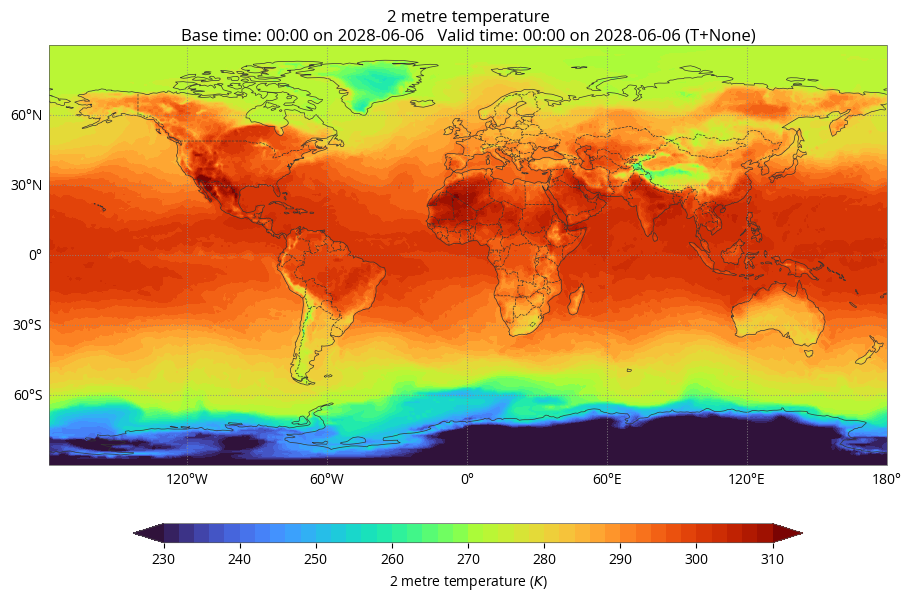

In [100]:
data = earthkit.data.from_source("file", filename)
data.ls
earthkit.maps.quickplot(data)

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action = "ignore", category = RuntimeWarning)